# Misc

In [6]:
# changing theme
# !jt -t chesterish 
# !jt -t onedork -fs 100 -altp -tfs 14 -nfs 115 -T
# restore default theme
#!jt -r

# Comparing fake and real faces

In [1]:
import sys 
sys.path.append(r'C:\Users\Jonas\PycharmProjects\IlkinThesis\ThesisExperiments')
from IPython.display import Image

import cv2
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import config
import cleaning_with_face_recognition as rec

In [47]:
# finds multiple face folders
folders = glob.glob(config.FACE_IMAGES + '/*')
metadata = pd.read_json(config.METADATA_PATH).T

for f in folders:
    imgs = glob.glob(f + '/*')
    if len(imgs) < 30:
        continue
    if metadata.loc[os.path.basename(f)]['label'] == 'REAL':
        continue
    print(f, len(imgs), metadata.loc[os.path.basename(f)]['original'])
    fake_path = f
    real_path = os.path.join(config.FACE_IMAGES, metadata.loc[os.path.basename(f)]['original'])
    break


outputs/faces_48\adrcjenxlz.mp4 39 qfzylqortq.mp4


## Helper classes & functions

In [26]:
class Face:
    def __init__(self, path):
        self.face = cv2.imread(path)
    
    def __sub__(self, other):
        diff = abs(self.face.astype('int') - other.face.astype('int'))
        return diff.astype('uint8')
    
    def get(self, type='rgb'):
        if type == 'bgr':
            return self.face
        elif type == 'rgb':
            return cv2.cvtColor(self.face, cv2.COLOR_BGR2RGB)
        elif type == 'gray':
            return cv2.cvtColor(self.face, cv2.COLOR_BGR2GRAY)

In [29]:
class Loader:
    def __init__(self, path):
        self.path = path
        self.names = glob.glob(path + '/*')
        
    def __getitem__(self, idx):
        return self.names[idx]
    
    def __len__(self):
        return len(self.names)

In [19]:
class Metadata:
    def __init__(self, path):
        self.metadata = pd.read_json(config.METADATA_PATH).T
    
    def __getitem__(self, name):
        return self.metadata.loc[name][['label','original']].values

In [41]:
def display_images(images, cols = 5):
    rows = len(images) // cols + 1
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)

## Processing

In [22]:
meta = Metadata(config.METADATA_PATH)
label, original = meta['kxchysmyhl.mp4']
print(label, original)

REAL nan


In [30]:
fake_path = os.path.join(config.FACE_IMAGES, 'syemxznzhs.mp4')
real_path = os.path.join(config.FACE_IMAGES, 'kxchysmyhl.mp4')

fakes = Loader(fake_path)
reals = Loader(real_path)

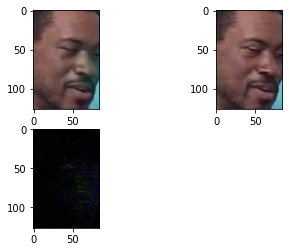

In [46]:
idx = 2
f1 = Face(fakes[idx])
f2 = Face(reals[idx])
    
display_images([f1.get('rgb'), f2.get('rgb'), f1-f2], 2)

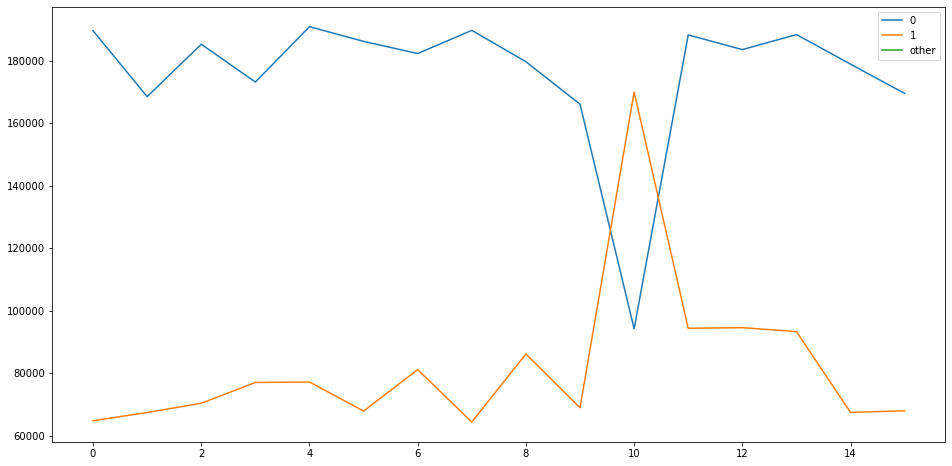

In [90]:
diff_fakes = []
diff_reals = []
diff_other = []

for f, r in zip(fakes, reals):
    assert f.split('mp4_')[-1] == r.split('mp4_')[-1], f'Fake: {f}, real: {r}'
        
    fake_face = Face(f)
    real_face = Face(r)
    diff = np.sum((fake_face - real_face).astype('int')) 
    
    identifier = f.split('_')[-1]
    if identifier == '0.jpg':
        diff_reals.append(diff)
        
    elif identifier == '1.jpg':
        diff_fakes.append(diff)
    else:
        diff_other.append(diff)

plt.figure(figsize=(16,8))
plt.plot(diff_reals, label='0')
plt.plot(diff_fakes, label='1')
plt.plot(diff_other, label='other')
plt.legend()

In [6]:
for i, (f, r) in enumerate(zip(fakes, reals)):
    fake_encoding = rec.get_encoding(f)
    real_encoding = rec.get_encoding(r)
    distance = np.linalg.norm(fake_encoding - real_encoding)
    
    img1 = cv2.imread(f)
    img2 = cv2.imread(f)
    cv2.imwrite(f'test/{i}_{distance}.jpg', np.hstack((img1, img2)))

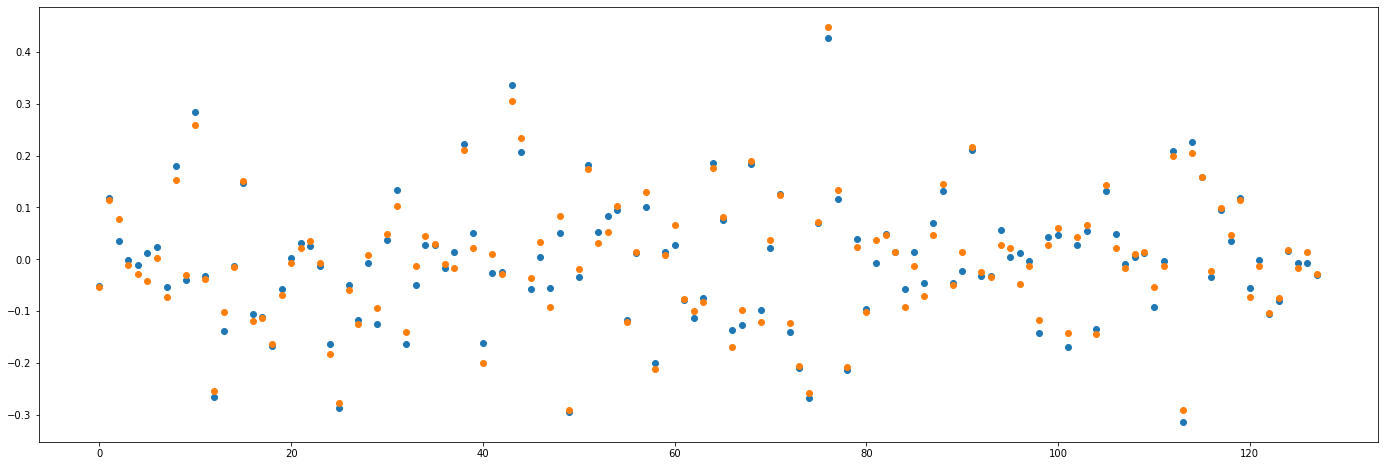

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,8))
fake_encoding = rec.get_encoding(fakes[0])
real_encoding = rec.get_encoding(reals[0])

plt.scatter(np.arange(len(fake_encoding)), fake_encoding)
plt.scatter(np.arange(len(real_encoding)), real_encoding)

# Possible cases


1. Single cluster
     1. single face - keep all
     2. multiple faces 
     3. single face & non-face
    
    
4. Multiple clusters
    1. Single face divided
    2. Single face cluster majority + artifact - keep majority
    3. Single face cluster + equally big artifact 
    4. Same length face clusters
    5. 2 same length face clusters + smaller artifact cluster
